In [1]:
import os
import sys
sys.path.append(os.path.abspath("../../src/"))
sys.path.append(os.path.abspath("/home/muzakka/Development/LHAPDF/"))
from tools import PDFs
import matplotlib.pyplot as plt
import numpy as np
import lhapdf
import scipy.integrate as integrate
from scipy.optimize import minimize
from scipy.optimize import differential_evolution
import scipy.optimize
import math
from scipy.interpolate import Rbf
from scipy.interpolate import interp1d
from scipy.interpolate import UnivariateSpline
import scipy
from matplotlib.ticker import (MultipleLocator, FormatStrFormatter,
                               AutoMinorLocator, NullFormatter)

In [2]:
a = np.loadtxt("p40/chi2.dat")
#chi2min = a[0]
#a= np.delete(a, 0)
print(np.average(a), np.std(a))
#print(chi2min, np.average(a))


5326.895697211155 154.60793311561613


In [6]:
a = np.loadtxt("p25/chi2.dat")
#chi2min = a[0]
a= np.delete(a, 0)
print(np.average(a), np.std(a))
#print(chi2min, np.average(a))


5332.662952646239 156.34740110570274


In [7]:
cov = np.loadtxt("p40/min.dat")
#cov_0= cov[0,:]
#cov = np.delete(cov, 0, axis=0)
ave = np.average(cov, axis=0)
print(ave)
cov = np.cov(cov, rowvar=False)
hess = np.linalg.inv(cov)
np.savetxt("min_replica_p40.txt", ave)
np.savetxt("hessian_replica_p40.txt", hess)

[-2.08770880e+00  7.59294701e-01 -2.04473769e-01  7.99936080e+00
 -3.64094622e-03 -7.19034088e-02 -4.24701701e-01 -7.70044988e-02
 -1.21734665e-01 -1.21575406e+00 -3.81493829e+00  1.95803753e+00
  1.61340721e+00 -4.66445920e-02  7.36238884e-03  3.43355944e-01
  5.06184422e-01  2.84285550e+00 -1.37881651e-02  5.04770853e-01
  6.40056418e-02  3.39357068e-02 -1.37164633e+00  2.06848594e+01
  5.06459936e-01  3.16649028e-01  2.23983343e+00  4.28508382e-02
  2.74578546e-01  5.00561088e-01 -2.76722924e-01 -1.25132680e-04
  6.79874948e+00  2.15517665e-01  4.79196624e-03 -1.31740649e-02
 -1.38591016e+00  1.05478790e-01  3.23174649e-01 -3.85676693e-01]


LHAPDF 6.5.1 loading all 252 PDFs in set Base_nCTEQ22_MC_208_82
Base_nCTEQ22_MC_208_82, version 1; 252 PDF members
LHAPDF 6.5.1 loading all 1 PDFs in set Base_nCTEQ22_TMC_HT_CTEQ_i2_208_82
Base_nCTEQ22_TMC_HT_CTEQ_i2_208_82, version 1; 1 PDF members
LHAPDF 6.5.1 loading all 43 PDFs in set nCTEQ15HIX_208_82
nCTEQ15HIX_208_82, version 1; 43 PDF members


posx and posy should be finite values


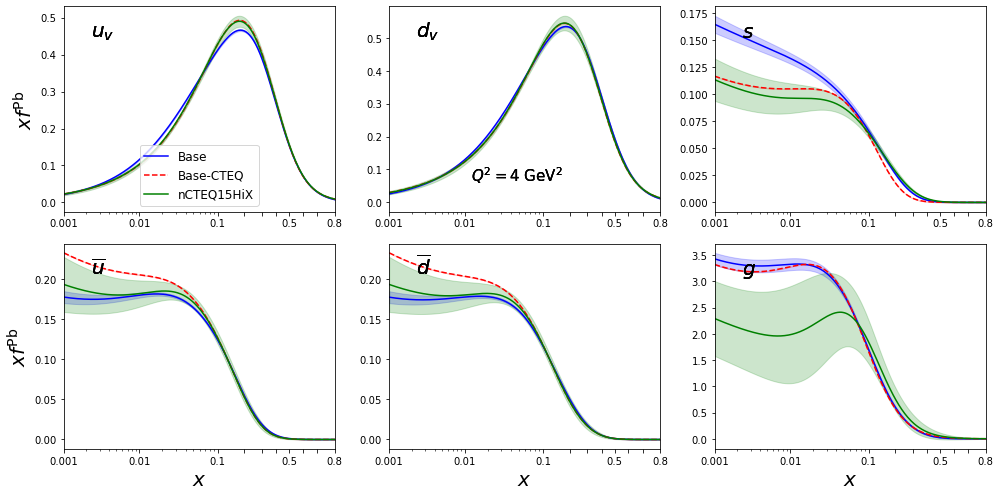

In [5]:
A=208
Z=82
base_MC_p40 = PDFs("Base_nCTEQ22_MC_"+str(A)+"_"+str(Z), "MCreplica", A, Z, True)
#base_MC_p25 = PDFs("Base_nCTEQ22_MC_p25_"+str(A)+"_"+str(Z), "MCreplica", A, Z, True)
#base_hess_p25 = PDFs("Base_nCTEQ22_"+str(A)+"_"+str(Z), "MCreplica", A, Z, True)
#base_MChess = PDFs("Base_nCTEQ22_MC_hess_"+str(A)+"_"+str(Z), "sym", A, Z, True)
base_cteq = PDFs("Base_nCTEQ22_TMC_HT_CTEQ_i2_"+str(A)+"_"+str(Z), "sym", A, Z, True)
#nnpdf = PDFs("nNNPDF30_nlo_as_0118_A208_Z82", "MCreplica", A, Z, False)
hix = PDFs("nCTEQ15HIX_"+str(A)+"_"+str(Z), "sym", A, Z, True)


mypdfs = [  [base_MC_p40, "blue", "-", "Base", True, 0.2], #pdf, color, linestyle, label, fullnuc, error, allpha
            #[base_MC_p25, "green", "-", "BaseMCp25", True, 0.4], #pdf, color, linestyle, label, fullnuc, error, allpha
            # [base_hess_p25, "red", "-", "BaseHessp25", True, 0.1], #pdf, color, linestyle, label, fullnuc, error, allpha
           #[base_MChess, "green", "dashed", "BaseMChess",  True, 0.1], 
             [base_cteq, "red", "dashed", "Base-CTEQ",  True, 0.2], 
            [hix, "green", "-", "nCTEQ15HiX",  True, 0.2],           
           # [nnpdf, "cyan", "-", "NNPDF",  True, 0.2]
]

flavors = ["uv", "dv", "s", "ubar", "dbar", "g"]
Q = 2.0
#xlist = np.linspace(0.001, 1.0,500)
xlist = np.logspace(-3,np.log10(0.95),300)
plt.figure(1,figsize=(14,7))
for iflv, flv in enumerate(flavors) :
    ax=plt.subplot2grid((2,3),(int(iflv/3), iflv%3))   
    plt.tight_layout()
    #plt.axhline(1.0, linestyle="dotted")
    #plt.axhline(0.0, linestyle="dotted")
    for i, pdf in enumerate(mypdfs) : 
        data, dp, dm = pdf[0].getPDFerrors(xlist, Q, flv)
        #print(dp, dm)
        if (i==0) : 
            dp = 1.645*dp 
            dm = 1.645*dm
        #elif (i==1) : 
        #    dp = np.sqrt(72/50)*dp 
        #    dm = np.sqrt(72/50)*dm
        data_cteq =1.0#, dpd, dmd = base.getPDFerrors(xlist, Q, flv)
        plt.plot(xlist, (data/data_cteq), color=pdf[1], linestyle=pdf[2], label = pdf[3])

        if (pdf[4]) : 
            plt.fill_between(xlist, ((data+dp)/data_cteq), ((data-dp)/data_cteq), color=pdf[1], alpha=pdf[5])

        flvlabel = "$"+flv+"$"
        if (flv == "uv") : 
            flvlabel = "$u_v$"
        elif (flv =="dv") : 
            flvlabel= "$d_v$"
        elif flv=="ubar" : 
            flvlabel = r"$\overline{u}$"
        elif flv=="dbar" : 
            flvlabel = r"$\overline{d}$"


        plt.xscale("logit" ,one_half="0.5")
        if int(iflv/3)==1 : 
            plt.xlabel(r'${x}$',fontsize=20)
        if (iflv%3 ==0) : 
            plt.ylabel(r'${xf^{{\mathrm{{Pb}}}}}$',fontsize=20, rotation=90)
        plt.annotate(flvlabel, xy=(0.1, 0.85), xycoords='axes fraction', fontsize=20)

        
        
        if (flv!="s") : 
            pass#plt.ylim(0.6, 1.4)
        else : 
            pass#plt.ylim(0., 2.4)

        if (iflv==0):
            plt.legend(loc="lower center", fontsize=12)
        if (iflv == 1) : 
            plt.annotate("$Q^2={}\ \mathrm{{GeV}}^2$".format(4), xy=(0.3, 0.15), xycoords='axes fraction', fontsize=15)
        #ax.set_xticklabels(["0","0.001", "0.01", "0.1","0.5","0.9", "0.95"])
        #plt.gca().set_ylim(bottom=0)
        ax.set_xticks([0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95])
        ax.set_xticklabels(["0.001", "0.01", "0.1","", "", "", "0.5","", "", "0.8","0.9", "0.95"])
        ax.xaxis.set_minor_formatter(NullFormatter())
        plt.xlim(0.001, 0.8)
        
plt.savefig("basepdfs_pb.pdf", bbox_inches="tight")

LHAPDF 6.5.1 loading all 252 PDFs in set Base_nCTEQ22_MC_56_26
Base_nCTEQ22_MC_56_26, version 1; 252 PDF members
LHAPDF 6.5.1 loading all 1 PDFs in set Base_nCTEQ22_dijet_56_26
Base_nCTEQ22_dijet_56_26, version 1; 1 PDF members
LHAPDF 6.5.1 loading all 1 PDFs in set Base_nCTEQ22_TMC_HT_CTEQ_i2_56_26
Base_nCTEQ22_TMC_HT_CTEQ_i2_56_26, version 1; 1 PDF members
LHAPDF 6.5.1 loading all 1 PDFs in set nCTEQ15WZSIH_1_1
nCTEQ15WZSIH_1_1, version 1; 1 PDF members
LHAPDF 6.5.1 loading all 252 PDFs in set Base_nCTEQ22_MC_1_1
Base_nCTEQ22_MC_1_1, version 1; 252 PDF members
LHAPDF 6.5.1 loading all 43 PDFs in set nCTEQ15HIX_56_26
nCTEQ15HIX_56_26, version 1; 43 PDF members


posx and posy should be finite values


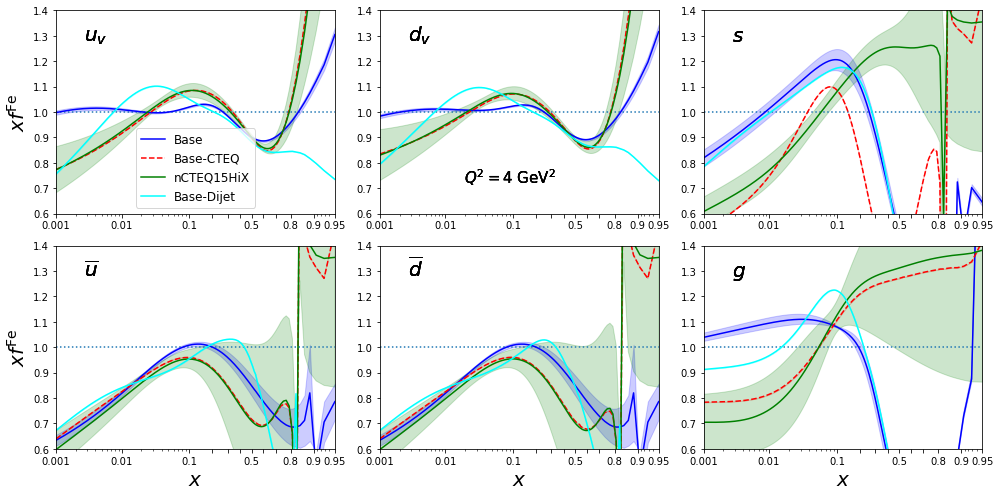

In [6]:
A=56
Z=26
base_MC_p40 = PDFs("Base_nCTEQ22_MC_"+str(A)+"_"+str(Z), "MCreplica", A, Z, True)
basedijet = PDFs("Base_nCTEQ22_dijet_"+str(A)+"_"+str(Z), "sym", A, Z, True)
#base_MC_p25 = PDFs("Base_nCTEQ22_MC_p25_"+str(A)+"_"+str(Z), "MCreplica", A, Z, True)
#base_hess_p25 = PDFs("Base_nCTEQ22_"+str(A)+"_"+str(Z), "MCreplica", A, Z, True)
#base_MChess = PDFs("Base_nCTEQ22_MC_hess_"+str(A)+"_"+str(Z), "sym", A, Z, True)
base_cteq = PDFs("Base_nCTEQ22_TMC_HT_CTEQ_i2_"+str(A)+"_"+str(Z), "sym", A, Z, True)
#nnpdf = PDFs("nNNPDF30_nlo_as_0118_A208_Z82", "MCreplica", A, Z, False)
basepcteq = PDFs("nCTEQ15WZSIH_1_1", "sym", A, Z, True)
basepcj =  PDFs("Base_nCTEQ22_MC_1_1", "sym", A, Z, True)
hix = PDFs("nCTEQ15HIX_"+str(A)+"_"+str(Z), "sym", A, Z, True)

mypdfs = [  [base_MC_p40, "blue", "-", "Base", True, 0.2], #pdf, color, linestyle, label, fullnuc, error, allpha
            #[base_MC_p25, "green", "-", "BaseMCp25", True, 0.4], #pdf, color, linestyle, label, fullnuc, error, allpha
            # [base_hess_p25, "red", "-", "BaseHessp25", True, 0.1], #pdf, color, linestyle, label, fullnuc, error, allpha
           #[base_MChess, "green", "dashed", "BaseMChess",  True, 0.1], 
             [base_cteq, "red", "dashed", "Base-CTEQ",  True, 0.2], 
            [hix, "green", "-", "nCTEQ15HiX",  True, 0.2], 
            [basedijet, "cyan", "-", "Base-Dijet",  True, 0.2],           
           # [nnpdf, "cyan", "-", "NNPDF",  True, 0.2]
]

flavors = ["uv", "dv", "s", "ubar", "dbar", "g"]
Q = 2.0
#xlist = np.linspace(0.001, 1.0,500)
xlist = np.logspace(-3,np.log10(0.95),300)
plt.figure(1,figsize=(14,7))
for iflv, flv in enumerate(flavors) :
    ax=plt.subplot2grid((2,3),(int(iflv/3), iflv%3))   
    plt.tight_layout()
    plt.axhline(1.0, linestyle="dotted")
    #plt.axhline(0.0, linestyle="dotted")
    for i, pdf in enumerate(mypdfs) : 
        data, dp, dm = pdf[0].getPDFerrors(xlist, Q, flv)
        data1, dpd1, dmd1 = basepcteq.getPDFerrors(xlist, Q, flv)
        data2, dpd2, dmd2 = basepcj.getPDFerrors(xlist, Q, flv)
        #print(dp, dm)
        if (i==0) : 
            dp = 1.645*dp 
            dm = 1.645*dm
        #elif (i==1) : 
        #    dp = np.sqrt(72/50)*dp 
        #    dm = np.sqrt(72/50)*dm
            data_cteq =data2#, dpd, dmd = base.getPDFerrors(xlist, Q, flv)
        else : 
            data_cteq = data1
        plt.plot(xlist, (data/data_cteq), color=pdf[1], linestyle=pdf[2], label = pdf[3])

        if (pdf[4]) : 
            plt.fill_between(xlist, ((data+dp)/data_cteq), ((data-dp)/data_cteq), color=pdf[1], alpha=pdf[5])

        flvlabel = "$"+flv+"$"
        if (flv == "uv") : 
            flvlabel = "$u_v$"
        elif (flv =="dv") : 
            flvlabel= "$d_v$"
        elif flv=="ubar" : 
            flvlabel = r"$\overline{u}$"
        elif flv=="dbar" : 
            flvlabel = r"$\overline{d}$"


        plt.xscale("logit" ,one_half="0.5")
        if int(iflv/3)==1 : 
            plt.xlabel(r'${x}$',fontsize=20)
        if (iflv%3 ==0) : 
            plt.ylabel(r'${xf^{{\mathrm{{Fe}}}}}$',fontsize=20, rotation=90)
        plt.annotate(flvlabel, xy=(0.1, 0.85), xycoords='axes fraction', fontsize=20)

        
        
        plt.ylim([0.6, 1.4])

        if (iflv==0):
            plt.legend(loc="lower center", fontsize=12)
        if (iflv == 1) : 
            plt.annotate("$Q^2={}\ \mathrm{{GeV}}^2$".format(4), xy=(0.3, 0.15), xycoords='axes fraction', fontsize=15)
        #ax.set_xticklabels(["0","0.001", "0.01", "0.1","0.5","0.9", "0.95"])
        #plt.gca().set_ylim(bottom=0)
        ax.set_xticks([0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95])
        ax.set_xticklabels(["0.001", "0.01", "0.1","", "", "", "0.5","", "", "0.8","0.9", "0.95"])
        ax.xaxis.set_minor_formatter(NullFormatter())
        plt.xlim(0.001, 0.95)
        
plt.savefig("basepdfs_fe.pdf", bbox_inches="tight")

LHAPDF 6.5.1 loading all 201 PDFs in set nNNPDF30_nlo_as_0118_p
nNNPDF30_nlo_as_0118_p, version 1; 201 PDF members
LHAPDF 6.5.1 loading all 1 PDFs in set nCTEQ15WZSIH_1_1
nCTEQ15WZSIH_1_1, version 1; 1 PDF members
LHAPDF 6.5.1 loading all 59 PDFs in set CT18ANLO
CT18ANLO, version 1; 59 PDF members
LHAPDF 6.5.1 loading all 49 PDFs in set CJ15nlo
CJ15nlo, version 2; 49 PDF members


posx and posy should be finite values


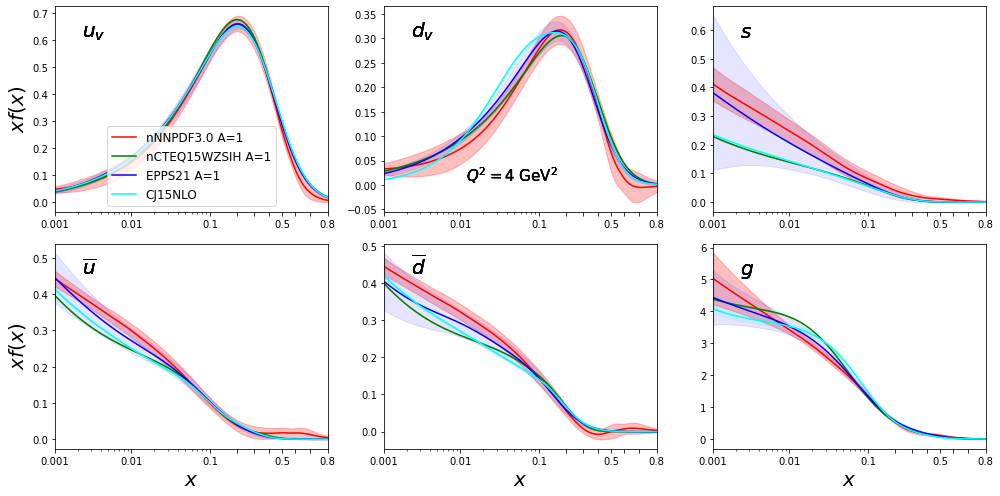

In [10]:
A=1
Z=1
nnnpdf30 = PDFs("nNNPDF30_nlo_as_0118_p", "MCreplica", A, Z, False)
base_cteq = PDFs("nCTEQ15WZSIH_"+str(A)+"_"+str(Z), "sym", A, Z, True)
epps21 =  PDFs("CT18ANLO", "sym", A, Z, True)
cj15nlo =  PDFs("CJ15nlo", "sym", A, Z, True)


mypdfs = [  [nnnpdf30, "red", "-", "nNNPDF3.0 A=1", True, 0.25], #pdf, color, linestyle, label, fullnuc, error, allpha
            [base_cteq, "green", "-", "nCTEQ15WZSIH A=1", True, 0.25], #pdf, color, linestyle, label, fullnuc, error, allpha
             [epps21, "blue", "-", "EPPS21 A=1", True, 0.1], #pdf, color, linestyle, label, fullnuc, error, allpha
              [cj15nlo, "cyan", "-", "CJ15NLO", True, 0.1], #pdf, color, linestyle, label, fullnuc, error, allpha
]

flavors = ["uv", "dv", "s", "ubar", "dbar", "g"]
Q = 2.0
#xlist = np.linspace(0.001, 1.0,500)
xlist = np.logspace(-3,np.log10(0.95),300)
plt.figure(1,figsize=(14,7))
for iflv, flv in enumerate(flavors) :
    ax=plt.subplot2grid((2,3),(int(iflv/3), iflv%3))   
    plt.tight_layout()
    #plt.axhline(1.0, linestyle="dotted")
    #plt.axhline(0.0, linestyle="dotted")
    for i, pdf in enumerate(mypdfs) : 
        data, dp, dm = pdf[0].getPDFerrors(xlist, Q, flv)
        #print(dp, dm)
        data_cteq =1.0#, dpd, dmd = base.getPDFerrors(xlist, Q, flv)
        plt.plot(xlist, (data/data_cteq), color=pdf[1], linestyle=pdf[2], label = pdf[3])

        if (pdf[4]) : 
            plt.fill_between(xlist, ((data+dp)/data_cteq), ((data-dp)/data_cteq), color=pdf[1], alpha=pdf[5])

        flvlabel = "$"+flv+"$"
        if (flv == "uv") : 
            flvlabel = "$u_v$"
        elif (flv =="dv") : 
            flvlabel= "$d_v$"
        elif flv=="ubar" : 
            flvlabel = r"$\overline{u}$"
        elif flv=="dbar" : 
            flvlabel = r"$\overline{d}$"


        plt.xscale("logit" ,one_half="0.5")
        if int(iflv/3)==1 : 
            plt.xlabel(r'${x}$',fontsize=20)
        if (iflv%3 ==0) : 
            plt.ylabel(r'${xf(x)}$',fontsize=20, rotation=90)
        plt.annotate(flvlabel, xy=(0.1, 0.85), xycoords='axes fraction', fontsize=20)

        
        
        if (flv!="s") : 
            pass#plt.ylim(0.6, 1.4)
        else : 
            pass#plt.ylim(0., 2.4)

        if (iflv==0):
            plt.legend(loc="lower center", fontsize=12)
        if (iflv == 1) : 
            plt.annotate("$Q^2={}\ \mathrm{{GeV}}^2$".format(4), xy=(0.3, 0.15), xycoords='axes fraction', fontsize=15)
        #ax.set_xticklabels(["0","0.001", "0.01", "0.1","0.5","0.9", "0.95"])
        #plt.gca().set_ylim(bottom=0)
        ax.set_xticks([0.001, 0.01, 0.1, 0.2, 0.3, 0.4, 0.5, 0.6, 0.7, 0.8, 0.9, 0.95])
        ax.set_xticklabels(["0.001", "0.01", "0.1","", "", "", "0.5","", "", "0.8","0.9", "0.95"])
        ax.xaxis.set_minor_formatter(NullFormatter())
        plt.xlim(0.001, 0.8)
        
plt.savefig("baseproton.pdf", bbox_inches="tight")

Fitting parameter :  0
Fitting parameter :  1
Fitting parameter :  2
Fitting parameter :  3
Fitting parameter :  4
[array([3.56089677e-03, 2.38768405e-05]), array([-0.05177765,  0.01573574]), array([ 0.70805129, -0.02903934]), array([ 0.05951366, -0.00493648]), array([ 0.00018597, -0.00187767])]
[1.591294053879114e-11, 0.0729833548249571, 0.0015629292970068284, 0.0003849093506386914, 9.247478717152685e-05]


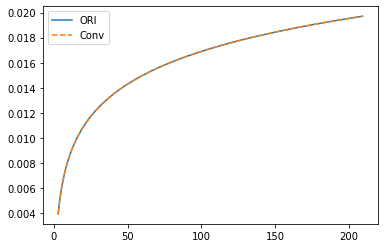

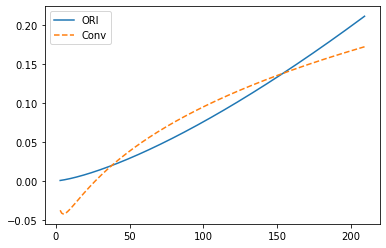

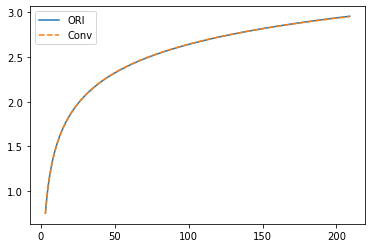

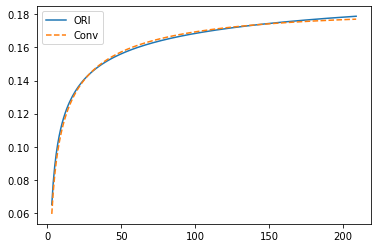

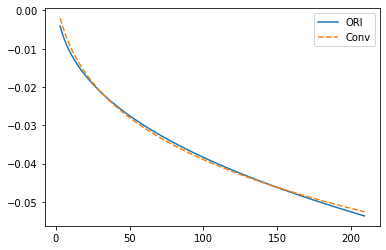

In [3]:
class Converter : 
    def __init__(self , pars) : 
        self.params = pars 
        self.Adata  = [i for i in range(3, 208)]
        self.Cdata = []
        for p in self.params : 
            self.Cdata.append([p[0]*(1.0-A**(-p[1])) for A in self.Adata])
        self.data = []

    def chi2 (self, p) : 
        theo = np.array([ (p[0] * np.log(A)+ p[1]* np.log(A)**2 ) for A in self.Adata])
        #theo = np.array([ (p[0] * np.log(A)**p[1] ) for A in self.Adata])
        return np.sum((theo-self.data)**2)

    def minimize (self, local=True) : 
        res = []
        fun =  []
        for i in range(len(self.params)) : 
            print("Fitting parameter : ", i)
            self.data = self.Cdata[i]
            if (local) : 
                bounds = (0.1, 0.1)
                result = minimize(self.chi2, bounds, method="Nelder-Mead")
            else : 
                bounds = [(-500,500), (-500, 500)]
                result = differential_evolution(self.chi2, bounds)
            
            result = minimize(self.chi2, result.x, method="Nelder-Mead")
            result = minimize(self.chi2, result.x, method="Nelder-Mead")
            result = minimize(self.chi2, result.x, method="L-BFGS-B")
            res.append(result.x) 
            fun.append(result.fun)

        print(res)
        print(fun)
        return res

pars_s = [[0.5052642822265625, 0.0457305908203125], 
        [ 0.3145656585693359, 0.26873779296875], 
        [2.173612594604492, 0.4956092834472656]
        ]
pars_uv = [ 
    [-2.090381622314453, -0.003610610961914062], 
    [0.7593116760253906, -0.07210922241210938], 
    [-0.2044868469238281, -0.4259319305419922], 
    [7.99683952331543, -0.07703208923339844]
]

pars_dv= [ 
    [-0.121734619140625, 1.610185623168945], 
    [1.219417572021484, -0.04747772216796875], 
    [-3.817220687866211, 0.007986068725585938], 
    [1.955776214599609, 0.3432445526123047]
]

pars_ubdb = [ 
    [0.5041103363037109, 0.0634918212890625], 
    [2.839807510375977, 0.03109931945800781 ], 
    [-0.01426506042480469,  -1.380508422851562], 
    [0.5006732940673828, 20.68239593505859]
]

pars_g = [  
    [-0.27557373046875, -0.01292800903320312],
    [-0.0001277923583984375, -1.387672424316406], 
    [6.796937942504883, 0.1069164276123047], 
    [0.2172813415527344, 0.3240985870361328], 
    [0.007715225219726562, -0.3882102966308594]
]
pars = pars_g
conv = Converter(pars)
mymin = conv.minimize(False)


Adata  = [i for i in range(3, 210)]
for i, p in enumerate(pars) : 
    plt.figure()
    ori = [p[0]* (1-A**(-p[1])) for A in Adata]
    con = [ (mymin[i][0]* np.log(A)+  mymin[i][1]* np.log(A)**2)  for A in Adata]
    #con = [ (mymin[i][0]* np.log(A)**mymin[i][1])  for A in Adata]
    plt.plot(Adata, ori, label="ORI")
    plt.plot(Adata, con, label="Conv", linestyle="dashed")
    plt.legend()
    #plt.xscale("log")
